## Offline analysis

here we will explore

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
plt.style.use('science')

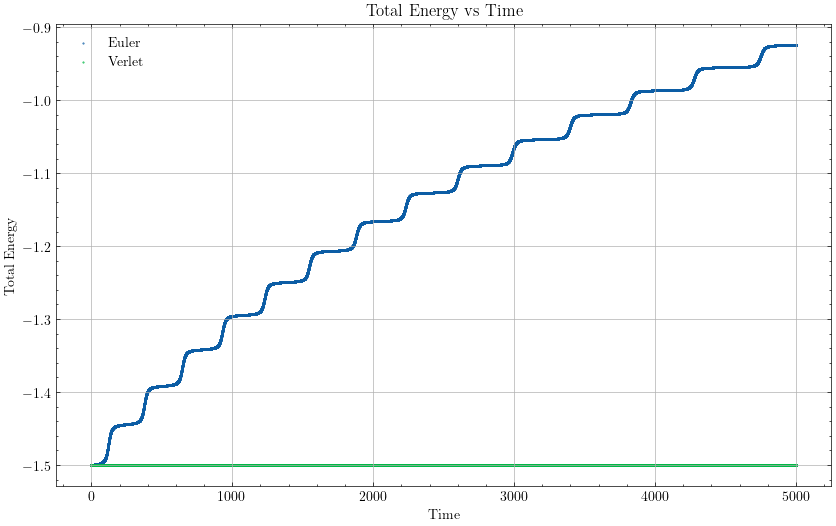

In [9]:
filenameEuler="../data/energy_N2_Euler.txt"
filenameVerlet="../data/energy_N2_Verlet.txt"

dataEuler = np.loadtxt(filenameEuler)
time = dataEuler[:,0]
energy = dataEuler[:,3]
kinetic = dataEuler[:,1]
potential = dataEuler[:,2]

dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]

plt.figure(figsize=(10,6))
plt.scatter(time, energy, marker='.', s=0.8, label='Euler')
plt.scatter(time, energyVerlet, marker='.', s=0.8, label='Verlet')
plt.xlabel("Time")
plt.ylabel("Total Energy")
plt.title("Total Energy vs Time")
plt.grid()
plt.legend()
plt.show()